In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import tensorflow as tf
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In this notebook I implemted Image Augmentation technqiue by which we can use 100 percent of real Time data for classification. And Use Mobile Net model for Training. Later I will try to make same technique for object detection data. 

In [ ]:
base_path = "/kaggle/input/global-wheat-detection/train/"
df = pd.read_csv("/kaggle/input/global-wheat-detection/train.csv")
print("Total Unique Images", len(set(df["image_id"].values)))
df.head()
print("Unique Sources {}".format(len(set(df["source"].values))))
print("Unique Sources {}".format((set(df["source"].values))))

**Merging Boudning box of all unique Images**

In [ ]:

unique_df={key: [] for key in (set(df["image_id"].values))}
for i in range(len(df)):
    unique_df[df["image_id"].iloc[i]].append(json.loads(df["bbox"].iloc[i]))
unique_df = pd.DataFrame(zip(list(unique_df.keys()),list(unique_df.values())), columns=['image_id', 'bbox'])
unique_df = pd.merge(unique_df, df, on='image_id').drop(["bbox_y"],axis=1).drop_duplicates(subset=["image_id"],keep="first", inplace=False)
unique_df.rename(columns={'bbox_x': 'bbox'}, inplace=True)
print("Unique Dataframe Length {}".format(len(unique_df)))
unique_df.head()

# Classification

In [ ]:

Images_from_source = unique_df.groupby('source').count()["image_id"]
print(Images_from_source)
print("Total Records",len(unique_df))
print("Cross Checking ",sum(list(Images_from_source)))
 
    #176 Minimum samples


                            

# Image Augmentation For Classification Problem

I think If we can do Image Augmentation like this we can use our 100% of real data.

I am using Image of 1024 * 1024 Diminsion

1. Take Image as it is and resize it to the Dimision you want.     (1024 * 1024 ---- > 256 * 256)
2. Slice image from different portions and resize them to the specefic diminsion  (1024 * 1024 ---- > Slice (512 * 512)) -----> (256 * 256)
3. Repeat this step according to the number of images you want.
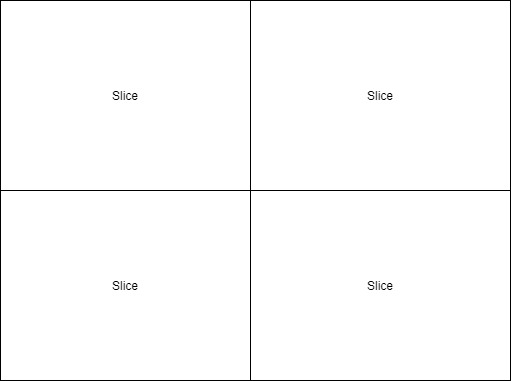

In [ ]:

import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw 
import json
import matplotlib.pyplot as plt

class augmentation:
    def imgcrop(self, im, label ,xPieces, yPieces, diminsion=(256,256)):
        sliced_images=[]
        labels=[]
        file_extension = "jpg"
        imgwidth, imgheight = im.size
        height = imgheight // yPieces
        width = imgwidth // xPieces
        for i in range(0, yPieces):
            for j in range(0, xPieces):
                box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
                croped_image = im.crop(box).resize(diminsion) 
                
                try:
                    sliced_images.append(np.asarray(croped_image))
                    labels.append(label)
                except:
                    pass
        return sliced_images , labels
    
    def run(self, images, labels):
        while(True):
            for index,image_id in enumerate(images):
                __sliced_images = []
                __summed_labels = []
                image, label = Image.fromarray(plt.imread(base_path + image_id + ".jpg")), labels[index]

                for i in range(1,2):
                    augmented_images, augmented_labels = self.imgcrop(image,label,i, i)
                    __sliced_images.extend(augmented_images)
                    __summed_labels.extend(augmented_labels)
                yield np.asarray(__sliced_images), np.asarray(__summed_labels)

generator=augmentation().run([unique_df["image_id"].iloc[1], unique_df["image_id"].iloc[16]], [unique_df["source"].iloc[1],unique_df["source"].iloc[16]])

counter = 0
for i in generator:
    
    _sliced_images, _labels = i              
    print("Total Images formed {} and Labels formed {}".format(len(_sliced_images), len(_labels)))
    for index,k in enumerate(_sliced_images):
        plt.title(_labels[index])
        plt.imshow(k)
        plt.show()
        counter = counter + 1
    
    if counter > 3:break
        
    


# Using MobilenetV2 

In [ ]:
"""MobileNet v2 models for Keras.
# Reference
- [Inverted Residuals and Linear Bottlenecks Mobile Networks for
   Classification, Detection and Segmentation]
   (https://arxiv.org/abs/1801.04381)
"""


from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D
from keras.utils.vis_utils import plot_model

from keras import backend as K


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)


def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1

    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)


def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)

    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))

    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    if r:
        x = Add()([x, inputs])

    return x


def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)

    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)

    return x


def MobileNetv2(input_shape, k, alpha=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model.
    """
    inputs = Input(shape=input_shape)

    first_filters = _make_divisible(32 * alpha, 8)
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))

    x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)

    if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_filters = 1280

    x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)

#     x = Activation('softmax', name='softmax')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation = 'relu')(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(k, activation = 'softmax')(x)
    
    
    
    output = Reshape((k,))(x)

    model = Model(inputs, output)
    # plot_model(model, to_file='images/MobileNetv2.png', show_shapes=True)
    model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(),metrics = ['accuracy','categorical_accuracy',
                                                                                             tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
    return model



model = MobileNetv2((256,256, 3), 7, 1.0)
print(model.summary())



In [ ]:
from keras.utils import to_categorical
   
images=list(unique_df["image_id"].values)
labels=list(unique_df["source"].values)

# Converting string to integer 
unique_labels = list(set(unique_df["source"].values))
labels_dict={i:unique_labels.index(i) for i in unique_labels}
labels=[labels_dict[label] for label in  labels]
label_df = pd.DataFrame(zip(list(labels_dict.keys()),list(labels_dict.values())), columns=['Label', 'Value'])
print(label_df)
label_df.to_csv("Label_dict.csv")

# Converting to Categorical Labels
labels = to_categorical(labels, num_classes=len(set(unique_df["source"].values)))

# test train Split 

Train_range=int(len(images)*0.7)

train_images_list=images[:Train_range]
train_labels_list=labels[:Train_range]
val_images_list=images[Train_range:]
val_labels_list=labels[Train_range:]


print("Train Images List" ,len(train_images_list))
print("train_labels_list" ,len(train_labels_list))
print("Val Images list" ,len(val_images_list))
print("Val Labels list" ,len(val_labels_list))

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
weights_path='/kaggle/working/MobileNet_{epoch}_{loss}.h5'
train = augmentation().run(train_images_list, train_labels_list)
validation = augmentation().run(val_images_list, val_labels_list)

model.fit_generator( train,
    steps_per_epoch=300,
    epochs = 1000,
    callbacks = [
                 ModelCheckpoint(weights_path,save_best_only=True,save_weights_only=True)
    ],
     validation_data=validation,
    validation_steps=200)

In [ ]:
import random
index = random.choice([i for i in range(len(next(validation)[0]))])
image = np.expand_dims(next(validation)[0][index],axis=0)
label = list(labels_dict.keys())[list(labels_dict.values()).index(next(validation)[1][index].argmax())]

prediction = model.predict(image)
predicted_label = list(labels_dict.keys())[list(labels_dict.values()).index(prediction.argmax())]

plt.title("GT: {}   Actual: {}".format(predicted_label,label))
plt.imshow(next(validation)[0][index])
plt.show()


# Sematic Segmentation by Unet

Will proceed this later

In [ ]:

for i in range(len(unique_df)):
    image = Image.open(base_path + unique_df["image_id"].iloc[i] + ".jpg")
    w, h = image.size
    bounding_box = unique_df["bbox"].iloc[i]
    
    for bbox in bounding_box:
        x,y,w,h=bbox
        shape = [x,y,x+w,y+h]
        img1 = ImageDraw.Draw(image)   
        img1.rectangle(shape,  outline ="white", width=5) 
    
    plt.title(unique_df["image_id"].iloc[i]+ " " + unique_df["source"].iloc[i])
    plt.imshow(np.asarray(image))
    plt.show()
    
    if i ==15:break
    


Unet

In [ ]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
smooth = 1
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)   

def dice_coef_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [dice_coef])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

**Image Augmentation**

Using Rotation for Object Detection Image Augmentation

In [ ]:
import skimage
import os
import cv2
import numpy as np
import math
from contextlib import suppress
import matplotlib.pyplot as plt


def MakeMask(bounding_box,width,height,image=[],debug=False):
    
    if not debug:
        image =  Image.new("RGB", (height,width)).convert('L')
        
        for bbox in bounding_box:
            x,y,w,h=bbox
            shape = [x,y,x+w,y+h]
            img1 = ImageDraw.Draw(image)   
            img1.rectangle(shape,  fill ="wheat")
    else:
        image=Image.fromarray(image)
        for bbox in bounding_box:
            x,y,w,h=bbox
            shape = [x,y,x+w,y+h]
            img1 = ImageDraw.Draw(image)   
            img1.rectangle(shape, outline ="wheat",width=10) 
    return np.asarray(image)


def adjustData(img,mask):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

def rotation(image,angelInDegrees):
    h,w = image.shape[:2]
    img_c = (w/2 , h/2)
    rot =cv2.getRotationMatrix2D(img_c, angelInDegrees,1)
    rad = math.radians(angelInDegrees)
    sin = math.sin(rad)
    cos = math.cos(rad)
    b_w= int((h * abs(sin))+ (w * abs(cos)))
    b_h = int((h*abs(cos)) + (w * abs(sin)))
    rot[0,2] += ((b_w / 2) - img_c[0])
    rot[1,2] += ((b_h /2) - (img_c[1]))
    outImg = cv2.warpAffine(image,rot,(b_w,b_h),flags= cv2.INTER_LINEAR)
    return outImg




def read_images(image_path, label,debug = False):
    image,mask,e=None,None,''
    
    if debug:
        with suppress(Exception) : image= cv2.imread(image_path)
        width,height,_ = image.shape
        mask = MakeMask(label,width,height,image=image,debug=debug)
        
    else:
        with suppress(Exception) : image= cv2.imread(image_path,0)
        width,height = image.shape
        mask = MakeMask(label,width,height,image=image,debug=debug)
        
    return image,mask

def ImageGenerator(images,labels,rotation_angel,resize_diminsion,batch_size,debug=False):
    image_list, label_list = [],[]
    while True:
        for index,image in enumerate(images):
            try:
                image,label=read_images(os.path.join(image),labels[index],debug)
                
                for count,angel in enumerate(range(0,360,rotation_angel)):
                    rot_label = cv2.resize(rotation(label,angel),resize_diminsion,interpolation = cv2.INTER_AREA)
                    rot_image = cv2.resize(rotation(image,angel),resize_diminsion,interpolation = cv2.INTER_AREA)
                    if not debug:
                        rot_image,rot_label = adjustData(rot_image,rot_label)
                    image_list.append(rot_image)
                    label_list.append(rot_label)
                    
                    if count % batch_size == 0 and count >= batch_size:
                        yield np.expand_dims(np.asarray(image_list),axis=3),np.expand_dims(np.asarray(label_list),axis=3)
                        image_list,label_list =[],[]
            except Exception as e:
                print(e)
            pass

def augment(images_path,label,rotation_angel=10,resize_diminsion=(256,256),batch_size=8,debug=False):
    percentage_of_training_data=0.7
    no_of_images=len(images_path)
    augment.TOTAL_TRAINING_IMAGES = (360 /rotation_angel) * no_of_images
    
    training_images = int(no_of_images * percentage_of_training_data)
    training_gen = ImageGenerator(images_path[0:training_images],label[0:training_images],rotation_angel,resize_diminsion,batch_size,debug)
    validation_gen = ImageGenerator(images_path[training_images:],label[training_images:],rotation_angel,resize_diminsion,batch_size,debug)
    return training_gen,validation_gen



In [ ]:
import random
images=[base_path+i+".jpg" for i in list(unique_df["image_id"].values)]
labels=list(unique_df["bbox"].values)

train,val=augment(images,labels,debug=False)
image,label=next(val)
index=random.choice([i-1 for i in range(image.shape[0])])
plt.title("Image")
plt.imshow(image[index].squeeze())
plt.show()
plt.title("Mask")
plt.imshow(label[index].squeeze())
plt.show()

# To be Continued

In [ ]:
# weights_path='/kaggle/working/Unet_{epoch}_{dice_coef}_{loss}.h5'
# model=unet(input_size=(256,256,1))
# model.fit_generator(
#     train,
#     steps_per_epoch=100,
#     epochs = 1000,
#     callbacks = [
#                  ModelCheckpoint(weights_path,save_best_only=True,save_weights_only=True)
#     ],
#      validation_data=val,
#     validation_steps=10)